In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, PALETTE_BLACK_ONLY

In [2]:
data = load_results_data()

100%|██████████| 874/874 [00:16<00:00, 54.21it/s]


In [3]:
MODELS_GLOW_COMPARISON = ["resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]
MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "lxmert", "bridgetower-large", "vilt", "clip", "imagebind", "flava", "blip2"]

all_data_glow_comparisons = data[data.model.isin(MODELS_GLOW_COMPARISON)]
all_data = data[data.model.isin(MODEL_ORDER)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data
# for model in MODEL_ORDER:
#     print(model, end=" ")
# all_data = all_data[all_data.subject.isin(['sub-01', 'sub-02', 'sub-03', 'sub-04'])]
# all_data_glow_comparisons

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,lang_features,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848265,lang_features_mean,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.847143,lang_features_mean,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.873061,lang_features_mean,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.860102,lang_features_mean,bert-base-uncased_lang
4,100000.0,bert-large-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.833673,lang_features_mean,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...
3491,100000.0,vit-b-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_mean,0.783367,n_a,vit-b-16_vision
3492,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.761939,n_a,vit-l-16_vision
3493,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_captions,0.696939,n_a,vit-l-16_vision
3494,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_images,0.920612,n_a,vit-l-16_vision


In [4]:
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "concat", "avg", "matched"]

DEFAULT_FEAT_OPTIONS = ["vision", "lang"] + FEATS_MULTIMODAL

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
multimodal_models
# for model in MODEL_ORDER:
#     print(model, end=" ")

all_data.model.unique()

array(['bert-base-uncased', 'bert-large-uncased', 'blip2',
       'bridgetower-large', 'clip', 'dino-base', 'dino-giant',
       'dino-large', 'flava', 'gpt2-large', 'gpt2-medium', 'gpt2-small',
       'gpt2-xl', 'imagebind', 'llama2-13b', 'llama2-7b', 'lxmert',
       'mistral-7b', 'mixtral-8x7b', 'resnet-152', 'resnet-18',
       'resnet-50', 'vilt', 'visualbert', 'vit-b-16', 'vit-l-16'],
      dtype=object)

In [5]:
# MODELS_EARLY_FUSION = ["vilt", "bridgetower-large", "visualbert", "lxmert"]
# FEATS_FUSED = ["fused_cls", "fused_mean", "fused_mean_features_safe", "fused_mean_features_two_step"]
# # Filter out outdated data from models with early fusion
# all_data = all_data[(all_data.model.isin(MODELS_EARLY_FUSION) & all_data.features.isin(FEATS_FUSED)) | ~all_data.model.isin(MODELS_EARLY_FUSION)]

## Feature comparison for multimodal models

In [6]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = get_default_vision_features(model)
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
# data_default_vision_feats

In [7]:
# feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean"}
# feat_order = ["vision", "lang", "fused_cls", "fused_mean", "matched", "avg", "concat"]
# feat_order_long = [feat_legend[feat] for feat in feat_order]

# data_to_plot = data_default_vision_feats.copy()

# model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_concat"]
# data_to_plot = data_to_plot[~data_to_plot.model_feat.isin(model_feats_exluded)].copy()

# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

# model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [8]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MODALITY_AGNOSTIC) & (all_data.training_mode == "modality-agnostic")]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc_modality_agnostic=('value', 'mean')).reset_index()
    grouped = grouped[grouped.model.isin(multimodal_models)]
    display(grouped)

# grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
# print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,count,pairwise_acc_modality_agnostic
2,blip2,avg,vision_features_cls,lang_features_cls,6,0.855833
3,blip2,avg,vision_features_cls,lang_features_mean,6,0.853997
4,blip2,avg,vision_features_mean,lang_features_cls,6,0.863724
5,blip2,avg,vision_features_mean,lang_features_mean,6,0.863401
6,blip2,concat,vision_features_cls,lang_features_cls,6,0.860663
7,blip2,concat,vision_features_cls,lang_features_mean,6,0.863401
8,blip2,concat,vision_features_mean,lang_features_cls,6,0.866259
9,blip2,concat,vision_features_mean,lang_features_mean,6,0.868963
10,blip2,fused_cls,n_a,n_a,6,0.712109
11,blip2,fused_mean,n_a,n_a,6,0.747364


## Feature comparison for GloW models

In [9]:
all_data_glow_comparisons
data_glow_mod_agnostic_train = all_data_glow_comparisons[(all_data_glow_comparisons.metric == ACC_MODALITY_AGNOSTIC) & (all_data_glow_comparisons.training_mode == "modality-agnostic")]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped_glow = data_glow_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc_modality_agnostic=('value', 'mean')).reset_index()
    display(grouped_glow)


,model,features,vision_features,lang_features,count,pairwise_acc_modality_agnostic
0,bge,lang,n_a,lang_features_cls,6,0.828061
1,glow,concat,vision_features_mean,lang_features_cls,1,0.849388
2,glow,lang,vision_features_mean,lang_features_cls,1,0.850714
3,glow,matched,vision_features_mean,lang_features_cls,6,0.841803
4,glow,vision,vision_features_mean,lang_features_cls,1,0.820510
5,glow-contrastive,concat,vision_features_mean,lang_features_cls,1,0.848061
6,glow-contrastive,lang,vision_features_mean,lang_features_cls,1,0.846735
7,glow-contrastive,matched,vision_features_mean,lang_features_cls,6,0.835578
8,resnet-50-glow,vision,vision_features_mean,n_a,6,0.805952
9,resnet-and-bge,concat,vision_features_mean,lang_features_cls,6,0.824490


## Modality-agnostic decoding vs. modality-specific decoding

In [10]:
data_default_feats = all_data.copy()
for model in all_data.model.unique():
    default_feats = get_default_features(model)
    default_vision_feats = get_default_vision_features(model)
    default_lang_feats = get_default_lang_features(model)
    data_default_feats = data_default_feats[((data_default_feats.model == model) & (data_default_feats.features == default_feats) & (data_default_feats.vision_features == default_vision_feats) & (data_default_feats.lang_features == default_lang_feats)) | (data_default_feats.model != model)]
    
data_default_feats

Selected default features for bert-base-uncased: lang
Selected default vision features for bert-base-uncased: n_a
Selected default lang features for bert-base-uncased: lang_features_mean
Selected default features for bert-large-uncased: lang
Selected default vision features for bert-large-uncased: n_a
Selected default lang features for bert-large-uncased: lang_features_mean
Selected default features for blip2: concat
Selected default vision features for blip2: vision_features_mean
Selected default lang features for blip2: lang_features_mean
Selected default features for bridgetower-large: fused_cls
Selected default vision features for bridgetower-large: n_a
Selected default lang features for bridgetower-large: n_a
Selected default features for clip: concat
Selected default vision features for clip: vision_features_cls
Selected default lang features for clip: lang_features_mean
Selected default features for dino-base: vision
Selected default vision features for dino-base: vision_feature

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,lang_features,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848265,lang_features_mean,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.847143,lang_features_mean,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.873061,lang_features_mean,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.860102,lang_features_mean,bert-base-uncased_lang
4,100000.0,bert-large-uncased,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.833673,lang_features_mean,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...
3491,100000.0,vit-b-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_mean,0.783367,n_a,vit-b-16_vision
3492,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.761939,n_a,vit-l-16_vision
3493,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_captions,0.696939,n_a,vit-l-16_vision
3494,100000.0,vit-l-16,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_images,0.920612,n_a,vit-l-16_vision


In [11]:
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
# for m in multimodal_models:
#     print(m, end=" ")


### Model performance ranking

In [12]:
model_order = ['random-flava']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == 'modality-agnostic']
    
    dp = dp[dp.metric == ACC_MODALITY_AGNOSTIC]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend(scores.index.values)
    
model_order

vision
model
resnet-152    0.768112
vit-b-16      0.777789
resnet-18     0.794660
vit-l-16      0.800204
resnet-50     0.808759
dino-large    0.816786
dino-base     0.820136
dino-giant    0.822466
Name: value, dtype: float64
lang
model
bert-large-uncased    0.813673
bert-base-uncased     0.828469
llama2-7b             0.837891
mixtral-8x7b          0.843010
mistral-7b            0.843844
gpt2-small            0.846922
gpt2-medium           0.850663
llama2-13b            0.851616
gpt2-xl               0.852483
gpt2-large            0.854235
Name: value, dtype: float64
fused_mean
model
visualbert    0.755901
lxmert        0.832466
vilt          0.846293
Name: value, dtype: float64
fused_cls
model
bridgetower-large    0.835629
Name: value, dtype: float64
concat
model
clip         0.859677
imagebind    0.864031
flava        0.867857
blip2        0.868963
Name: value, dtype: float64
avg
matched


['random-flava',
 'resnet-152',
 'vit-b-16',
 'resnet-18',
 'vit-l-16',
 'resnet-50',
 'dino-large',
 'dino-base',
 'dino-giant',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'gpt2-small',
 'gpt2-medium',
 'llama2-13b',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'lxmert',
 'vilt',
 'bridgetower-large',
 'clip',
 'imagebind',
 'flava',
 'blip2']

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


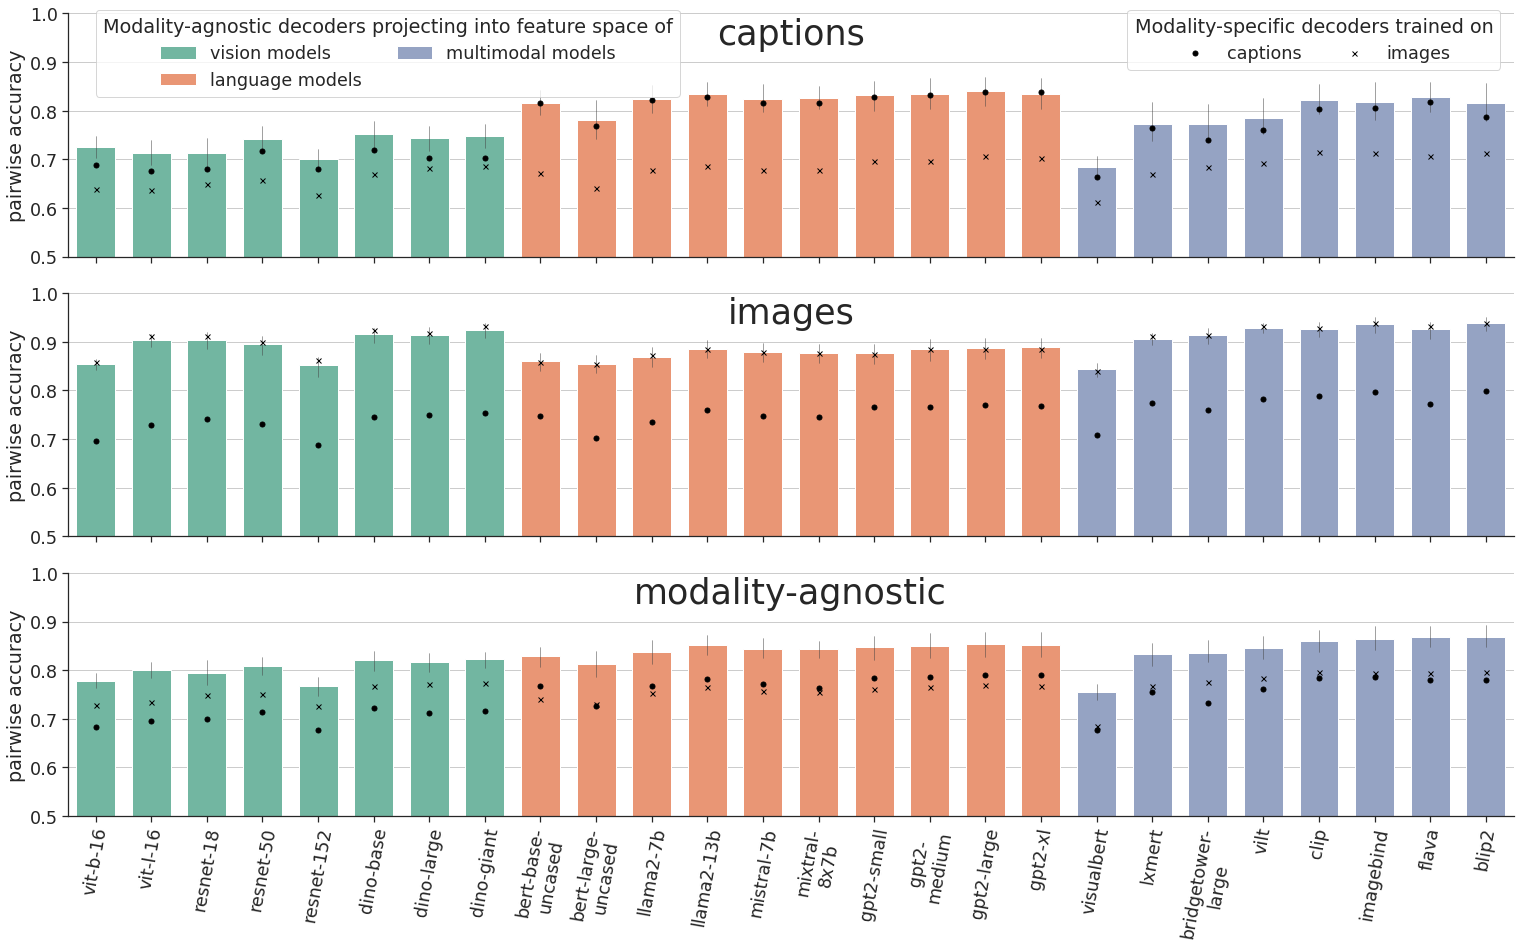

In [13]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [14]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
#                              legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False,
#                              plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_only_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## CLS or mean feats for vision models

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


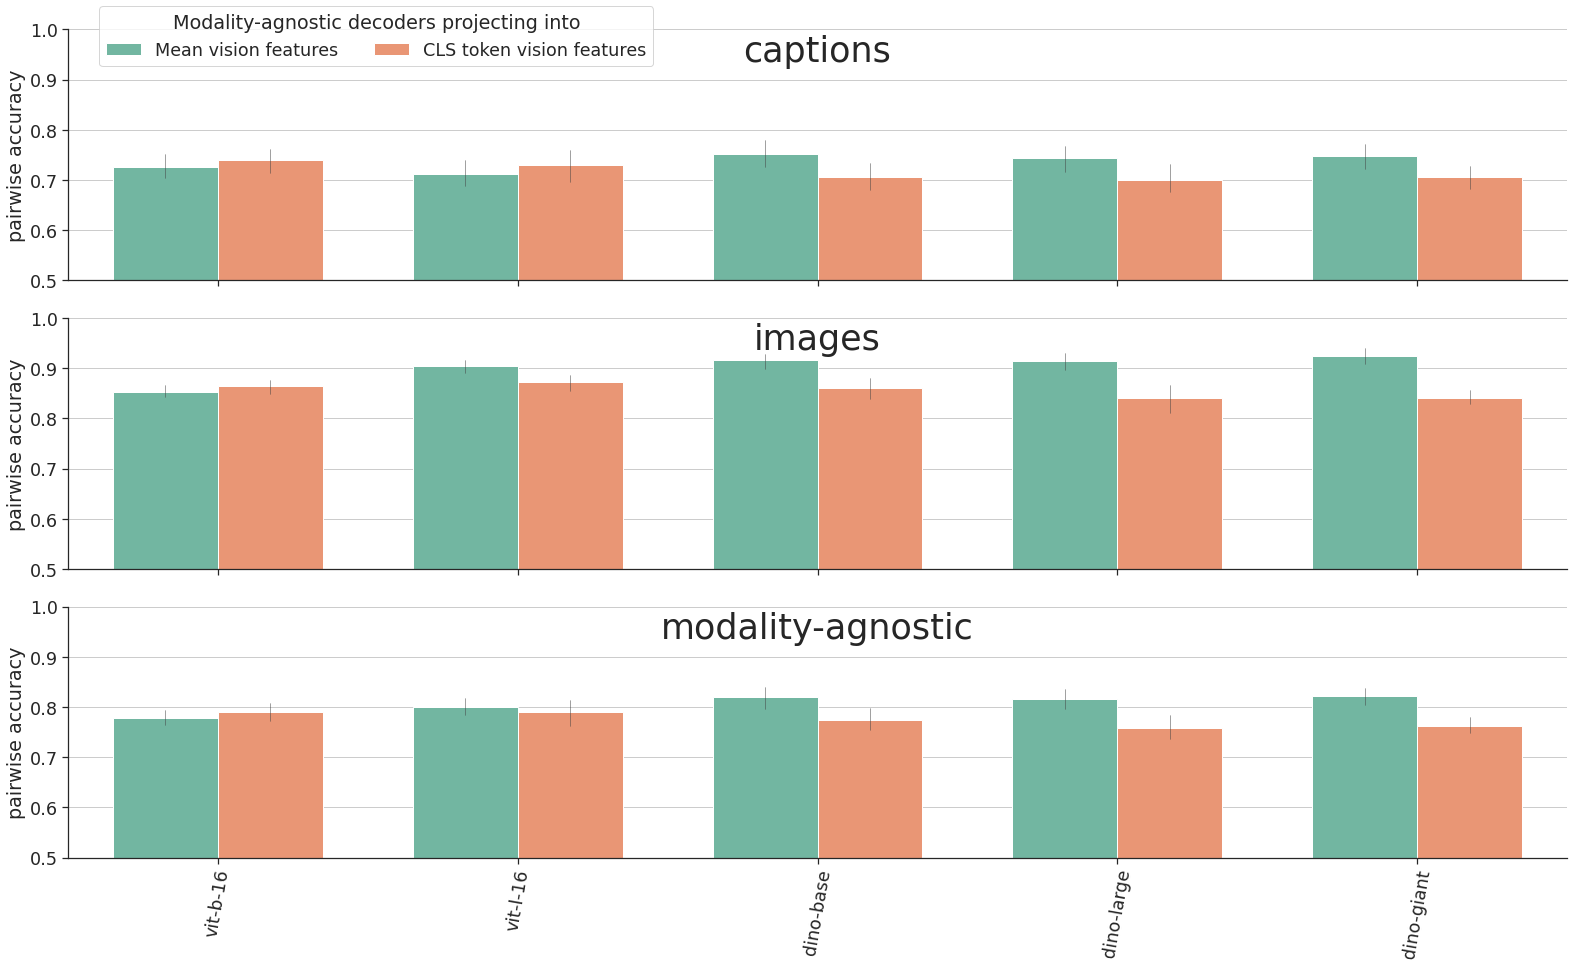

In [15]:
data_to_plot = all_data.copy()

vision_models_both_options = [m for m in vision_models if len(data_to_plot[data_to_plot.model == m].vision_features.unique()) == 2]
data_to_plot = data_to_plot[data_to_plot.model.isin(vision_models_both_options)]

vision_feat_order = ["Mean vision features", "CLS token vision features"]
data_to_plot["vision_features"] = data_to_plot.vision_features.replace({"vision_features_mean": "Mean vision features", "vision_features_cls": "CLS token vision features"})

data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="vision_features", hue_order=vision_feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.0), height=4.5, legend_title="Modality-agnostic decoders projecting into", plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_vision_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Per-subject results

In [16]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


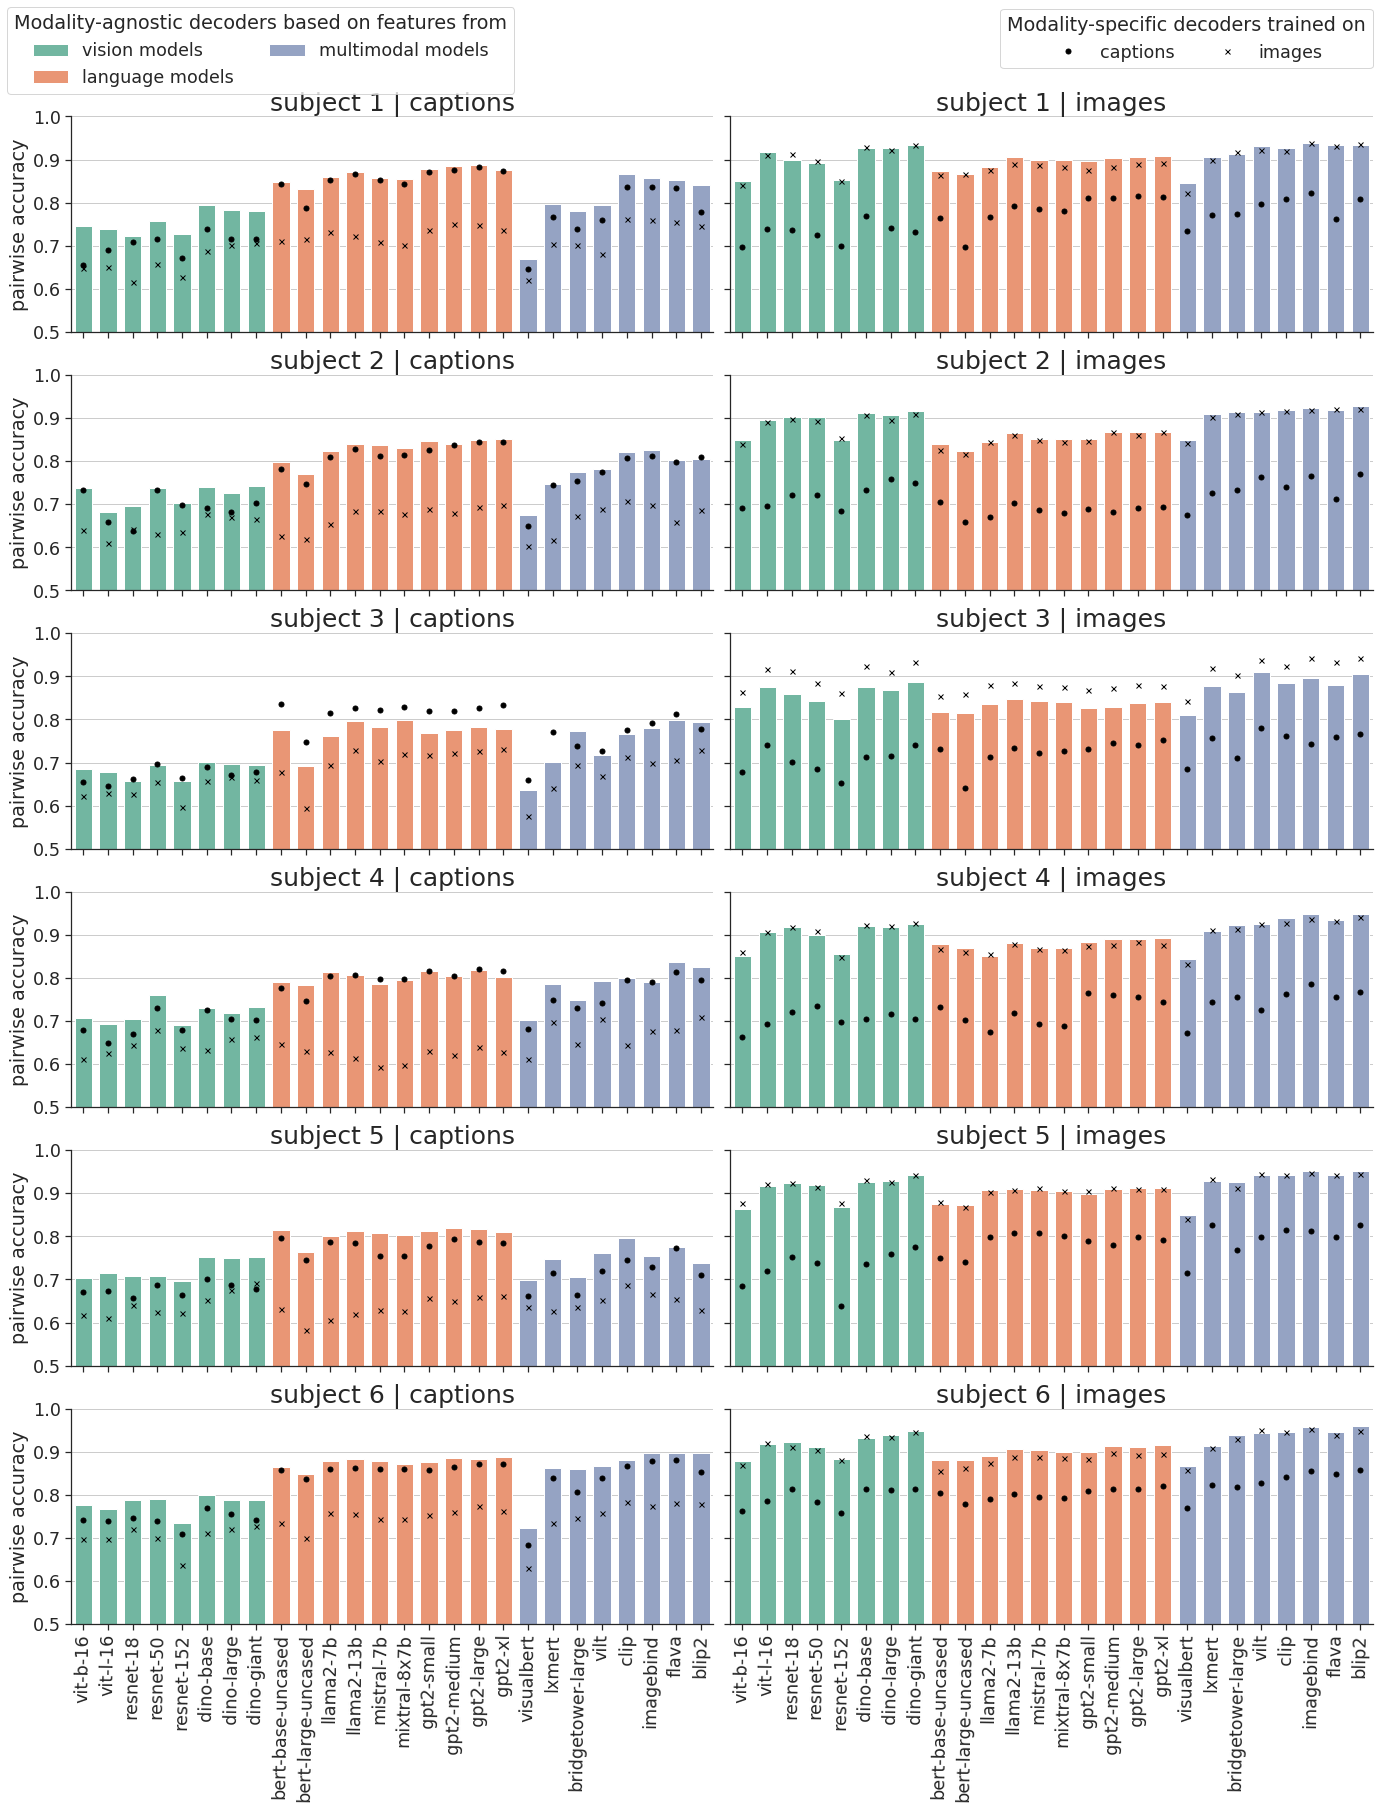

In [17]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)